In [1]:
import numpy as np
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DATA_PATH = "data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data)
data = np.array(data, dtype='float32')

In [3]:
from sklearn.model_selection import TimeSeriesSplit

epochs = 3000
k = 1
tscv = TimeSeriesSplit(n_splits=2, test_size=int(np.size(data, axis=0)*0.1))
i = 0
labels = np.array(labels)

for i, (train_index, test_index) in enumerate(tscv.split(data)):
    if i == 0:
        continue
    ae_model = model.LSTMAutoEncoder(input_size=np.size(data, axis=1)).to(device)
    loss = nn.MSELoss()
    # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
    optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
    train_labels = labels[train_index]
    test_labels = labels[test_index]
    X_train, X_test = data[train_index][train_labels==0], data[test_index]
    for epoch in range(epochs):
        print(f"\n=====epoch {epoch}/{epochs}=====")
        train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer, batch_size=np.size(data, axis=0))

    res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
    # break


=====epoch 0/3000=====
loss: 0.790951  [21843/21843]

=====epoch 1/3000=====
loss: 0.789861  [21843/21843]

=====epoch 2/3000=====
loss: 0.788875  [21843/21843]

=====epoch 3/3000=====
loss: 0.787955  [21843/21843]

=====epoch 4/3000=====
loss: 0.787057  [21843/21843]

=====epoch 5/3000=====
loss: 0.786143  [21843/21843]

=====epoch 6/3000=====
loss: 0.785178  [21843/21843]

=====epoch 7/3000=====
loss: 0.784136  [21843/21843]

=====epoch 8/3000=====
loss: 0.782996  [21843/21843]

=====epoch 9/3000=====
loss: 0.781695  [21843/21843]

=====epoch 10/3000=====
loss: 0.780180  [21843/21843]

=====epoch 11/3000=====
loss: 0.778440  [21843/21843]

=====epoch 12/3000=====
loss: 0.776433  [21843/21843]

=====epoch 13/3000=====
loss: 0.774095  [21843/21843]

=====epoch 14/3000=====
loss: 0.771333  [21843/21843]

=====epoch 15/3000=====
loss: 0.768153  [21843/21843]

=====epoch 16/3000=====
loss: 0.764439  [21843/21843]

=====epoch 17/3000=====
loss: 0.760055  [21843/21843]

=====epoch 18/3000=

0.9292808971814832


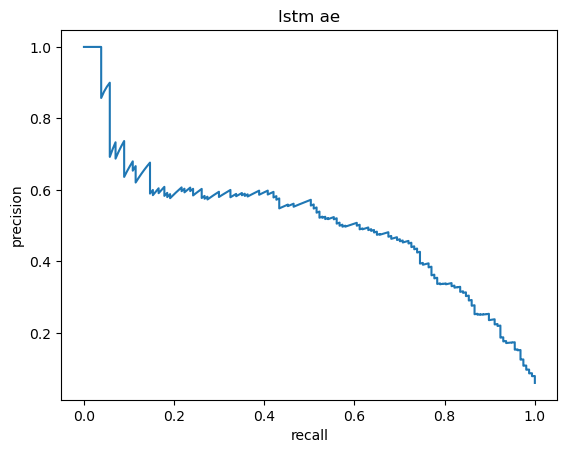

In [12]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in test_labels]
point_size = [0.1 if label == 0 else 10 for label in test_labels]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(test_labels, res)

precision, recall, threshold = metrics.precision_recall_curve(test_labels, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("lstm ae")
plt.show()

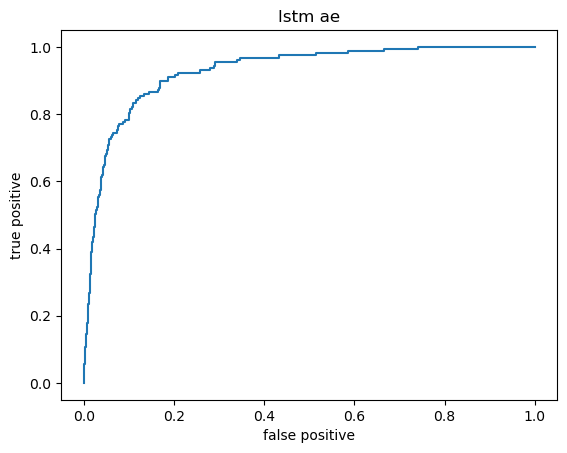

In [9]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("lstm ae")
plt.show()